In [1]:
import itertools
import random
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook as tqdm
import pandas as pd
import time

%matplotlib inline

In [2]:
def make_random_graph_list(V_size, E_size):
    network_list = np.array([np.random.choice(range(V_size),2,replace=False) for i in range(E_size)])
    network_list = np.unique(network_list, axis=0)
    weighted = np.random.uniform(0,1,len(network_list))
    
    # from to と　weightedを連結
    return np.vstack([network_list.T, weighted]).T

In [3]:
def compute_ap(ap, S, MIIA_v, MIIA_MIP_v, G):
    # MIIAtreeの末端から計算すれば、効率的になるため、ソート
    sorted_path_len = sorted(MIIA_MIP_v.items(), key=lambda x:len(x[1]), reverse=True)
    
    for u, _ in sorted_path_len:
        if u in S:
            ap[(u, MIIA_v)] = 1
        else:
            N_in = MIIA_v.in_edges([u])
            if not N_in:
                ap[(u, MIIA_v)] = 0
            else:
                prod = 1
                for w, _ in N_in:
                    prod *= 1 - ap[(w, MIIA_v)] * G[w][u]["weight"]
                ap[(u, MIIA_v)] = 1 - prod

In [4]:
def compute_alpha(alpha, v, MIIA_v, MIIA_MIP_v, S, G, ap):
    # 木のルートからはじめると効率的に計算できる
    sorted_path_len = sorted(MIIA_MIP_v.items(), key=lambda x:len(x[1]))

    for u, _ in sorted_path_len:
        if u == v:
            alpha[(MIIA_v, u)] = 1
        else:
            w = list(MIIA_v.out_edges([u]))[0][1]
            if w in S:
                alpha[(MIIA_v, u)] = 0
            else:
                N_in = MIIA_v.in_edges([w])
                prod = 1
                for u_, _ in N_in:
                    if u_ != u:
                        prod *= 1 - ap[(u_, MIIA_v)] * G[u_][w]["weight"]
                alpha[(MIIA_v, u)] = alpha[(MIIA_v, w)] * G[u][w]["weight"] * prod

In [5]:
def compute_PMIOA(v, theta, S, G):

    PMIOA = nx.DiGraph()
    PMIOA.add_node(v)
    PMIOA_MIP = {v: [v]}

    crossing_edges = set([out_edge for out_edge in G.out_edges([v]) if out_edge[1] not in S + [v]])
    edge_weights = dict()
    dist = {v: 0}

    # grow PMIOA
    while crossing_edges:
        # Dijkstra's greedy criteria
        min_dist = float("Inf")
        #sorted_crossing_edges = sorted(crossing_edges) # to break ties consistently
        sorted_crossing_edges = crossing_edges # to break ties consistently
        for edge in sorted_crossing_edges:
            if edge not in edge_weights:
                edge_weights[edge] = -np.log(G[edge[0]][edge[1]]["weight"])
            edge_weight = edge_weights[edge]
            # 更新条件
            if dist[edge[0]] + edge_weight < min_dist:
                min_dist = dist[edge[0]] + edge_weight
                min_edge = edge
        # check stopping criteria
        if min_dist < -np.log(theta):
            dist[min_edge[1]] = min_dist
            PMIOA.add_edge(min_edge[0], min_edge[1])
            PMIOA_MIP[min_edge[1]] = PMIOA_MIP[min_edge[0]] + [min_edge[1]]
            # update crossing edges
            crossing_edges.difference_update(G.in_edges(min_edge[1]))
            crossing_edges.update([out_edge for out_edge in G.out_edges(min_edge[1]) 
                                   if (out_edge[1] not in PMIOA) and (out_edge[1] not in S)])
        else:
            break
    return PMIOA, PMIOA_MIP

In [6]:
def compute_PMIIA(v, theta, S, IS_v, G):

    PMIIA = nx.DiGraph()
    PMIIA.add_node(v)
    PMIIA_MIP = {v: [v]}

    crossing_edges = set([in_edge for in_edge in G.in_edges([v]) if in_edge[0] not in IS_v + [v]])
    #print("start", crossing_edges)
    edge_weights = dict()
    dist = {v: 0} # shortest paths from the root u

    # grow PMIIA
    while crossing_edges:
        # Dijkstra's greedy criteria
        min_dist = float("Inf")
        #sorted_crossing_edges = sorted(crossing_edges) # to break ties consistently
        sorted_crossing_edges = crossing_edges # to break ties consistently
        for edge in sorted_crossing_edges:
            if edge not in edge_weights:
                edge_weights[edge] = -np.log(G[edge[0]][edge[1]]["weight"])
            edge_weight = edge_weights[edge]
            # 更新条件
            if dist[edge[1]] + edge_weight < min_dist:
                min_dist = dist[edge[1]] + edge_weight
                min_edge = edge
        # check stopping criteria
        if min_dist < -np.log(theta):
            dist[min_edge[0]] = min_dist
            PMIIA.add_edge(min_edge[0], min_edge[1])
            PMIIA_MIP[min_edge[0]] = PMIIA_MIP[min_edge[1]] + [min_edge[0]]
            # update crossing edges
            crossing_edges.difference_update(G.out_edges(min_edge[0]))
            if min_edge[0] not in S:
                crossing_edges.update([in_edge for in_edge in G.in_edges(min_edge[0]) 
                                       if (in_edge[0] not in PMIIA) and (in_edge[0] not in IS_v)])
                #print("cros_edges update", crossing_edges)
        else:
            break
    return PMIIA, PMIIA_MIP

In [7]:
# 入力uはシードに追加されるノード
def update_IS(IS, S, u, PMIOA_MIP, PMIIA_MIP):
    # uがシードに追加されるので、IncInfを更新する際は、このuからの影響を更新すれば良いため、PMIOA[u]を考える
    # PMIOA_MIP[u]:root_uから出ていく木のパス
    # v:uから到達できるノード(影響を及ぼされるノード)
    for v in PMIOA_MIP[u]:
        # si:ブロックされる(後続にシードがある)可能性のあるシード
        for si in S:
            # if seed node is effective and it's blocked by u
            # then it becomes ineffective
            
            # PMIIA[v]:root_vに入ってくる木のパス
            # そのパスの中にsiがある場合(PMIIA_MIP[v][si]:siからvまでのパス)
            # siからvまでのパスのなかにuが含まれていると、siからuまでのパスが二通りになり、木であることに矛盾してしまう
            if (si in PMIIA_MIP[v]) and (si not in IS[v]) and (u in PMIIA_MIP[v][si]):
                IS[v].append(si)

In [8]:
def PMIA(G, k, theta):
    start = time.time()
    # initialization
    S = []
    IncInf = dict(zip(G.nodes(), [0]*len(G)))
    PMIIA = dict() # node to tree
    PMIOA = dict()
    PMIIA_MIP = dict() # node to MIPs (dict)
    PMIOA_MIP = dict()
    ap = dict()
    alpha = dict()
    IS = dict()
    
    for v in tqdm(G):
        IS[v] = []
        PMIIA[v], PMIIA_MIP[v] = compute_PMIIA(v, theta, S, IS[v], G)
        for u in PMIIA[v]:
            ap[(u, PMIIA[v])] = 0 # ap of u node in PMIIA[v]
        compute_alpha(alpha, v, PMIIA[v], PMIIA_MIP[v], S, G, ap)
        for u in PMIIA[v]:
            IncInf[u] += alpha[(PMIIA[v], u)]*(1 - ap[(u, PMIIA[v])])
    
    # main loop
    for i in range(k):
        u = sorted(IncInf.items(), key=lambda x:x[1], reverse=True)[0][0]
        print("u",u)
        # print i+1, "node:", u, "-->", IncInf[u]
        IncInf.pop(u) # exclude node u for next iterations
        PMIOA[u], PMIOA_MIP[u] = compute_PMIOA(u, theta, S, G)
        for v in PMIOA[u]:
            for w in PMIIA[v]:
                if w not in S + [u]:
                    IncInf[w] -= alpha[(PMIIA[v],w)]*(1 - ap[(w, PMIIA[v])])

        update_IS(IS, S, u, PMIOA_MIP, PMIIA_MIP)
        S.append(u)

        for v in PMIOA[u]:
            if v != u:
                PMIIA[v], PMIIA_MIP[v] = compute_PMIIA(v, theta, S, IS[v], G)
                compute_ap(ap, S, PMIIA[v], PMIIA_MIP[v], G)
                compute_alpha(alpha, v, PMIIA[v], PMIIA_MIP[v], S, G, ap)
                # add new incremental influence
                for w in PMIIA[v]:
                    if w not in S:
                        IncInf[w] += alpha[(PMIIA[v], w)]*(1 - ap[(w, PMIIA[v])])

    return S

In [9]:
# ランダムグラフで行う場合

In [12]:
nt = make_random_graph_list(1000,2000)

In [13]:
k = 3
theta = 0.2
# 空の有向グラフを作成
G = nx.DiGraph()
# 重み付きの枝を加える
G.add_weighted_edges_from(nt)

In [14]:
%time PMIA(G, 5, 1/320)


u 388.0
u 797.0
u 787.0
u 203.0
u 362.0
CPU times: user 7min 52s, sys: 55.9 s, total: 8min 48s
Wall time: 13min 15s


[388.0, 797.0, 787.0, 203.0, 362.0]

In [15]:
# # IS挙動の確認用
# def PMIA(G, k, theta):
#     start = time.time()
#     # initialization
#     S = []
#     IncInf = dict(zip(G.nodes(), [0]*len(G)))
#     PMIIA = dict() # node to tree
#     PMIOA = dict()
#     PMIIA_MIP = dict() # node to MIPs (dict)
#     PMIOA_MIP = dict()
#     ap = dict()
#     alpha = dict()
#     IS = dict()
    
#     for v in G:
#         IS[v] = []
#         PMIIA[v], PMIIA_MIP[v] = compute_PMIIA(v, theta, S, IS[v], G)
#         for u in PMIIA[v]:
#             ap[(u, PMIIA[v])] = 0 # ap of u node in PMIIA[v]
#         compute_alpha(alpha, v, PMIIA[v], PMIIA_MIP[v], S, G, ap)
#         for u in PMIIA[v]:
#             IncInf[u] += alpha[(PMIIA[v], u)]*(1 - ap[(u, PMIIA[v])])
    
#     # main loop
#     for i in range(k):
#         u = sorted(IncInf.items(), key=lambda x:x[1], reverse=True)[0][0]
#         print("u",u)
#         # print i+1, "node:", u, "-->", IncInf[u]
#         IncInf.pop(u) # exclude node u for next iterations
#         PMIOA[u], PMIOA_MIP[u] = compute_PMIOA(u, theta, S, G)
#         for v in PMIOA[u]:
#             for w in PMIIA[v]:
#                 if w not in S + [u]:
#                     IncInf[w] -= alpha[(PMIIA[v],w)]*(1 - ap[(w, PMIIA[v])])
                   
#         for i in PMIOA[u]:
#             for s in S:
#                 if (s in PMIIA_MIP[i]) and (u in PMIIA_MIP[i][s]):
#                     print("Seedからrootにたどり着く間にuを通るか",S,i,u)
#                     nx.draw_networkx(PMIIA[i])
#                     plt.show()
#                     print("****************uを通った*****************")
        
#         # ISの更新が怪しい特にS
#         update_IS(IS, S, u, PMIOA_MIP, PMIIA_MIP)
#         print("IS",IS)
#         S.append(u)

#         for v in PMIOA[u]:
#             if v != u:
#                 PMIIA[v], PMIIA_MIP[v] = compute_PMIIA(v, theta, S, IS[v], G)
#                 compute_ap(ap, S, PMIIA[v], PMIIA_MIP[v], G)
#                 compute_alpha(alpha, v, PMIIA[v], PMIIA_MIP[v], S, G, ap)
#                 # add new incremental influence
#                 for w in PMIIA[v]:
#                     if w not in S:
#                         IncInf[w] += alpha[(PMIIA[v], w)]*(1 - ap[(w, PMIIA[v])])

#     return S

# PMIA(G, 5, 0.001)

# データを読み込んで行う場合

In [16]:
# データの読み込み
# 枝確率を計算済みのネットワークを読み込む
network = pd.read_csv("data.csv")
network.head()

# numpy型に変換
network_np = network.values

# 空の有向グラフを作成
G = nx.DiGraph()

# 重み付きの枝を加える
G.add_weighted_edges_from(network_np)

(array([172.,  16.,  20.,   0.,   6.,   0.,   0.,   0.,   0.,   2.]),
 array([0.0625 , 0.15625, 0.25   , 0.34375, 0.4375 , 0.53125, 0.625  ,
        0.71875, 0.8125 , 0.90625, 1.     ]),
 <a list of 10 Patch objects>)

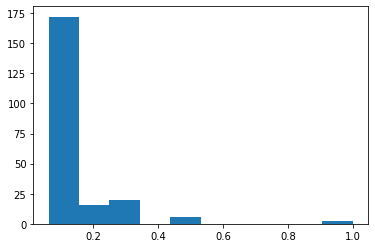

In [18]:
plt.hist(network["WC"])

In [19]:
def PMIA_init_time(G, k, theta):
    # initialization
    S = []
    IncInf = dict(zip(G.nodes(), [0]*len(G)))
    PMIIA = dict() # node to tree
    PMIOA = dict()
    PMIIA_MIP = dict() # node to MIPs (dict)
    PMIOA_MIP = dict()
    ap = dict()
    alpha = dict()
    IS = dict()
    
    time_list = np.array([])
    
    for v in tqdm(G):
        IS[v] = []
        
        start = time.time()
        PMIIA[v], PMIIA_MIP[v] = compute_PMIIA(v, theta, S, IS[v], G)
        time_list = np.append(time_list, time.time() - start)
        
        start = time.time()
        for u in PMIIA[v]:
            ap[(u, PMIIA[v])] = 0 # ap of u node in PMIIA[v]
        time_list = np.append(time_list, time.time() - start)
            
        start = time.time()
        compute_alpha(alpha, v, PMIIA[v], PMIIA_MIP[v], S, G, ap)
        time_list = np.append(time_list, time.time() - start)
        
        start = time.time()
        for u in PMIIA[v]:
            IncInf[u] += alpha[(PMIIA[v], u)]*(1 - ap[(u, PMIIA[v])])
        time_list = np.append(time_list, time.time() - start)
        
    return time_list

# どこの処理に時間がかかっているのかを計測する

In [20]:
%time time_list = PMIA_init_time(G, 5, 0.9)


CPU times: user 77.8 ms, sys: 33.6 ms, total: 111 ms
Wall time: 443 ms


In [21]:
time_df = pd.DataFrame(time_list.reshape(-1,4), columns=["PMIIA", "ap", "alpha", "IncInf"])
time_df

,PMIIA,ap,alpha,IncInf
0,0.001052,0.000007,0.000017,0.000005
1,0.019576,0.000007,0.000014,0.000006
2,0.000309,0.000004,0.000012,0.000006
3,0.000124,0.000004,0.000009,0.000004
4,0.000143,0.000004,0.000008,0.000005
5,0.000101,0.000004,0.000008,0.000005
6,0.000206,0.000004,0.000008,0.000004
7,0.000173,0.000003,0.000008,0.000005
8,0.018330,0.000012,0.000021,0.000015
9,0.000616,0.000010,0.000120,0.000016


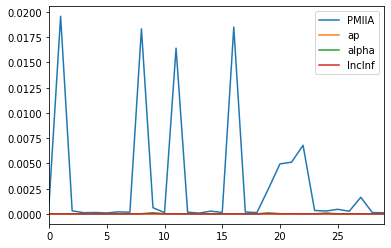

In [22]:
time_df.plot()

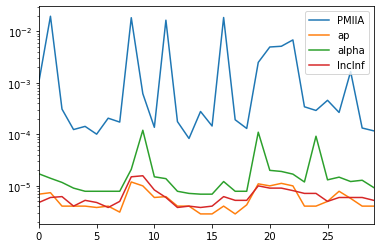

In [23]:
time_df.plot(logy=True)

# グラフの規模を変えた時に計算時間がどのように変化するのかを計測する

In [24]:
def PMIA_ordertime(G, k, theta):
    start = time.time()
    # initialization
    S = []
    IncInf = dict(zip(G.nodes(), [0]*len(G)))
    PMIIA = dict() # node to tree
    PMIOA = dict()
    PMIIA_MIP = dict() # node to MIPs (dict)
    PMIOA_MIP = dict()
    ap = dict()
    alpha = dict()
    IS = dict()
    
    time_list = np.array([])
    
    for v in G:
        IS[v] = []
        
        PMIIA[v], PMIIA_MIP[v] = compute_PMIIA(v, theta, S, IS[v], G)
        
        for u in PMIIA[v]:
            ap[(u, PMIIA[v])] = 0 # ap of u node in PMIIA[v]
            
        compute_alpha(alpha, v, PMIIA[v], PMIIA_MIP[v], S, G, ap)
        
        for u in PMIIA[v]:
            IncInf[u] += alpha[(PMIIA[v], u)]*(1 - ap[(u, PMIIA[v])])
            
    init_time = time.time() - start
            
    # main loop
    k_time = []
    for i in tqdm(range(k)):
        start = time.time()
        
        u = sorted(IncInf.items(), key=lambda x:x[1], reverse=True)[0][0]

        # print i+1, "node:", u, "-->", IncInf[u]
        IncInf.pop(u) # exclude node u for next iterations
        PMIOA[u], PMIOA_MIP[u] = compute_PMIOA(u, theta, S, G)
        for v in PMIOA[u]:
            for w in PMIIA[v]:
                if w not in S + [u]:
                    IncInf[w] -= alpha[(PMIIA[v],w)]*(1 - ap[(w, PMIIA[v])])

        update_IS(IS, S, u, PMIOA_MIP, PMIIA_MIP)
        S.append(u)

        for v in PMIOA[u]:
            if v != u:
                PMIIA[v], PMIIA_MIP[v] = compute_PMIIA(v, theta, S, IS[v], G)
                compute_ap(ap, S, PMIIA[v], PMIIA_MIP[v], G)
                compute_alpha(alpha, v, PMIIA[v], PMIIA_MIP[v], S, G, ap)
                # add new incremental influence
                for w in PMIIA[v]:
                    if w not in S:
                        IncInf[w] += alpha[(PMIIA[v], w)]*(1 - ap[(w, PMIIA[v])])
        k_time.append(time.time() - start)
    return init_time, k_time

In [ ]:
# ランダムネットワークを作成

init_times = []

k = 50
k_times = []
k_times.append(list(range(1,k+1)))
for i in tqdm(range(1000,5001,500)):
    nt = make_random_graph_list(i, i*2)

    # インスタンスの作成
    
    theta = 1/320
    G = nx.DiGraph()
    # 重み付きの枝を加える
    G.add_weighted_edges_from(nt)

    # 時間を計測
    init_time, k_time = PMIA_ordertime(G, k, theta)
    
    init_times.append(i)
    init_times.append(init_time)
    
    k_times.append(k_time)

In [ ]:
init_times = np.array(init_times).reshape(-1,2)

In [ ]:
init_times_df = pd.DataFrame(init_times,columns=["V_size","init_time"]).set_index("V_size")
init_times_df.head()

In [ ]:
k_times = np.array(k_times).reshape(len(init_times_df)+1, -1).T
k_times

In [ ]:
k_times_df = pd.DataFrame(k_times).set_index(0)
k_times_df

In [ ]:
init_times_df.plot()

In [ ]:
k_times_df.plot()

# 計算実験

In [10]:
def PMIA_time(G, k, theta):
    start = time.time()
    # initialization
    S = []
    IncInf = dict(zip(G.nodes(), [0]*len(G)))
    PMIIA = dict() # node to tree
    PMIOA = dict()
    PMIIA_MIP = dict() # node to MIPs (dict)
    PMIOA_MIP = dict()
    ap = dict()
    alpha = dict()
    IS = dict()
    
    time_list = []
    
    for v in tqdm(G):
        IS[v] = []
        PMIIA[v], PMIIA_MIP[v] = compute_PMIIA(v, theta, S, IS[v], G)
        for u in PMIIA[v]:
            ap[(u, PMIIA[v])] = 0 # ap of u node in PMIIA[v]
        compute_alpha(alpha, v, PMIIA[v], PMIIA_MIP[v], S, G, ap)
        for u in PMIIA[v]:
            IncInf[u] += alpha[(PMIIA[v], u)]*(1 - ap[(u, PMIIA[v])])
    print("comp init")
    
    # main loop
    for i in range(k):
        start = time.time()
        u = sorted(IncInf.items(), key=lambda x:x[1], reverse=True)[0][0]
        print("u",u)
        # print i+1, "node:", u, "-->", IncInf[u]
        IncInf.pop(u) # exclude node u for next iterations
        PMIOA[u], PMIOA_MIP[u] = compute_PMIOA(u, theta, S, G)
        for v in PMIOA[u]:
            for w in PMIIA[v]:
                if w not in S + [u]:
                    IncInf[w] -= alpha[(PMIIA[v],w)]*(1 - ap[(w, PMIIA[v])])

        update_IS(IS, S, u, PMIOA_MIP, PMIIA_MIP)
        S.append(u)

        for v in PMIOA[u]:
            
            if v != u:
                PMIIA[v], PMIIA_MIP[v] = compute_PMIIA(v, theta, S, IS[v], G)
                compute_ap(ap, S, PMIIA[v], PMIIA_MIP[v], G)
                compute_alpha(alpha, v, PMIIA[v], PMIIA_MIP[v], S, G, ap)
                # add new incremental influence
                for w in PMIIA[v]:
                    if w not in S:
                        IncInf[w] += alpha[(PMIIA[v], w)]*(1 - ap[(w, PMIIA[v])])
        time_list.append(time.time() - start)

    return S, time_list

## Epinions

In [11]:
run_time = dict([])
S = dict([])

### WC

In [12]:
# 枝確率を計算済みのネットワークを読み込む
network = pd.read_csv("data/Epinions/WC.csv")
network.head()

,# FromNodeId,ToNodeId,WC
0,0,4,0.008000
1,0,5,0.005682
2,0,7,0.033333
3,0,8,0.009615
4,0,9,0.066667


In [13]:
# numpy型に変換
network_np = network.values

# 空の有向グラフを作成
G = nx.DiGraph()

# 重み付きの枝を加える
G.add_weighted_edges_from(network_np)

In [15]:
start = time.time()
S["WC"], time_list = PMIA_time(G, 50, 1/320)
run_time["WC"] = time.time() - start


comp init
u 763.0


KeyboardInterrupt: 

In [ ]:
WC_df_seed_time = pd.DataFrame({"Size of Seed Set":range(1,51), 
                                "Running Time[s]":time_list}).set_index("Size of Seed Set")
WC_df_seed_time

In [ ]:
WC_df_seed_time.plot()

In [ ]:
run_time["WC"]

In [ ]:
S["WC"]

### TR

In [ ]:
# 枝確率を計算済みのネットワークを読み込む
network = pd.read_csv("data/Epinions/TR.csv")
network.head()

In [ ]:
# numpy型に変換
network_np = network.values

# 空の有向グラフを作成
G = nx.DiGraph()

# 重み付きの枝を加える
G.add_weighted_edges_from(network_np)

In [ ]:
start = time.time()
S["TR"], time_list = PMIA_time(G, 50, 1/320)
run_time["TR"] = time.time() - start

In [ ]:
TR_df_seed_time = pd.DataFrame({"Size of Seed Set":range(1,51), 
                                "Running Time[s]":time_list}).set_index("Size of Seed Set")
TR_df_seed_time

In [ ]:
TR_df_seed_time.plot()

In [ ]:
run_time["TR"]

In [ ]:
S["TR"]

### P=0.1

In [ ]:
# 枝確率を計算済みのネットワークを読み込む
network = pd.read_csv("data/Epinions/P=0_1.csv")
network.head()

In [ ]:
# numpy型に変換
network_np = network.values

# 空の有向グラフを作成
G = nx.DiGraph()

# 重み付きの枝を加える
G.add_weighted_edges_from(network_np)

In [ ]:
start = time.time()
S["P=0_1"], time_list = PMIA_time(G, 50, 1/320)
run_time["P=0_1"] = time.time() - start

In [ ]:
P01_df_seed_time = pd.DataFrame({"Size of Seed Set":range(1,51), 
                                "Running Time[s]":time_list}).set_index("Size of Seed Set")
P01_df_seed_time

In [ ]:
P01_df_seed_time.plot()

In [ ]:
run_time["P=0_1"]

In [ ]:
S["P=0_1"]